# Hierarchical Differential Expression
### This notebook runs differential expression at every node of the ontology tree

# Prepare
### load necessary pacakges

In [2]:
import sys
import os 
homedir = '/data/'
sys.path.append(homedir + 'scVI/')
sys.path.append(homedir + 'tabula-sapiens/')
sys.path.append(homedir + 'cellontology/')
from cellontology import CellOntolgy
import anndata
import obonet 
import pickle as pkl
from scvi.dataset import AnnDatasetFromAnnData
from utils.annotations_utils import *
from anndata import read_h5ad
import scanpy as sc

from copy import deepcopy
retrain=False

import matplotlib
%matplotlib inline

In [10]:
import networkx as nx

## set directories for reading and saving results

In [3]:
data_path = homedir + 'TabulaSapiensData/'
model_path = homedir + 'TabulaSapiens/scVImodels_final/'
res_path = homedir + 'TabulaSapiensData/combined/'
ont_path =  homedir + 'TabulaSapiensData/ontology/'


if not os.path.exists(model_path):
    os.mkdir(model_path)
if not os.path.exists(model_path+'scanvi/'):
    os.mkdir(model_path+'scanvi/')
if not os.path.exists(res_path):
    os.mkdir(res_path)

In [4]:
ontology = pkl.load(open(ont_path + 'ontology.pkl', 'rb'))

In [6]:
combined = read_h5ad(data_path + 'combined/Pilot1_Pilot2.Final.h5ad')
combined.obs['propagated_cell_ontology_class'].replace('duodenum glandular cells','duodenum glandular cell',inplace=True)
combined.obs['manual_cell_ontology_class'].replace('duodenum glandular cells','duodenum glandular cell', inplace=True)

del combined.raw
combined = combined[combined.obs['propagated_cell_ontology_class']!='unassigned']

label_conversion = {}
for x in ontology.nodes:
    label_conversion[ontology.nodes[x]['name']] = x

combined.obs['propagated_cell_ontology_id'] = [label_conversion[x] for x in combined.obs['propagated_cell_ontology_class']]

Trying to set attribute `.obs` of view, copying.


# this is the function that computes the number of cells in each child node

In [8]:
def NodeInfo(ontology, root, labels):
    node_info = {}
    all_children = [x for x in nx.ancestors(ontology,root)]
    all_children = all_children 
    subset = [x in all_children for x in labels]
    if len(all_children)==0:
        return {root:(np.sum(labels==root),[])}
    if np.sum(subset)==0:
        return {root:(np.sum(subset),[])}
    count = np.sum(subset)
    groups = [x for x in ontology.predecessors(root)]
    node_info[root] = (count, groups)
    if len(groups) > 1:
        for x in groups:
            sub_node_info = NodeInfo(ontology, x, labels)
            if sub_node_info is not None:
                for y in sub_node_info.keys():
                    node_info[y] = sub_node_info[y]            
                    
    else:
        sub_node_info = NodeInfo(ontology, groups[0], labels)
        if sub_node_info is not None:
            for y in sub_node_info.keys():
                node_info[y] = sub_node_info[y]
    return node_info

In [12]:
nodeinfo = NodeInfo(ontology,'CL:0000000',combined.obs['propagated_cell_ontology_id'])

# these are the functions that runs the DE
### WilcoxonDE run wilcoxon 
### Hierarchical DE: function to iterate over the tree and perform DE through either Wilcoxon or scVI at every node between all of its children

In [15]:
def WilcoxonDE(adata, subset, labels):
    sub_adata = adata[subset]
    sub_adata.obs['group'] = np.asarray(labels)[subset]
    if len(np.unique(sub_adata.obs['group']))==1:
        return None

    else:
        sc.pp.filter_genes(sub_adata,min_cells=10)
        sc.pp.filter_cells(sub_adata,min_counts=10)
        sc.tl.rank_genes_groups(sub_adata, groupby='group')
        return(sub_adata.uns['rank_genes_groups'])

In [26]:
def HierarchicalDE(ontology, root, labels, adata, method='Wilcoxon', posterior=None):
    print(root)
    all_children = [x for x in nx.ancestors(ontology,root)]
    all_children = all_children 
    subset = [x in all_children for x in labels]
    if len(all_children)==0:
        return None
    if np.sum(subset)==0:
        print('no cells', ontology.nodes[root]['name'])
        return None
    groups = [x for x in ontology.predecessors(root)]
    DE_res = {}
    if len(groups) > 1:
        label_group = {}
        for x in groups:
            label_group[x] = x
            groups_children = [y for y in nx.ancestors(ontology,x)]
            for y in groups_children:
                label_group[y] = x
            sub_DE_res = HierarchicalDE(ontology, x, labels, combined, method=method, posterior=posterior)
            if sub_DE_res is not None:
                for y in sub_DE_res.keys():
                    DE_res[y] = sub_DE_res[y]            
                    
        group_labels = []
        for x in labels: 
            if x in label_group.keys():
                group_labels.append(label_group[x])
            else:
                group_labels.append('None')
        
        group_labels = np.asarray(group_labels)
        
        if len(np.unique(group_labels[subset]))==1:
            print(label_group)
            print('Some groups have 0 cells resulting in only one group in comparison',ontology.nodes[root]['name'])
            sub_DE_res = HierarchicalDE(ontology, groups[0], labels, combined, method=method, posterior=posterior)
            if sub_DE_res is not None:
                for y in sub_DE_res.keys():
                    DE_res[y] = sub_DE_res[y]
            return DE_res
        else:
            print(np.sum(subset))
            if method=='Wilcoxon':
                DE_res[root] = WilcoxonDE(adata, subset, group_labels)
            elif method=='scVI':
                assert posterior is not None
                group_names, group_labels = np.unique(group_labels, return_inverse=True)
                print(np.unique(group_labels))
                a,b = posterior.one_vs_all_degenes(subset=subset, cell_labels=group_labels, mode='change')
                DE_res[root] = (a,b,group_names)
            return DE_res
    else:
        sub_DE_res = HierarchicalDE(ontology, groups[0], labels, combined, method=method, posterior=posterior)
        if sub_DE_res is not None:
            for y in sub_DE_res.keys():
                DE_res[y] = sub_DE_res[y]
        return DE_res

# Wilcoxon

In [17]:
DEres = HierarchicalDE(ontology, 'CL:0000000', combined.obs['propagated_cell_ontology_id'], combined, method='Wilcoxon')

CL:0000000
CL:0000003
CL:0000064
CL:1000271
CL:0000151
CL:4000014
CL:4000024
CL:0008024


Trying to set attribute `.obs` of view, copying.


CL:0000169
CL:0000171
CL:0000173
547


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.


CL:1000331
2495


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


CL:0000183
CL:0000186
CL:0000669
CL:0000192
CL:0000359
CL:0002598


Trying to set attribute `.obs` of view, copying.


1890


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.


6637


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


CL:0002371


Trying to set attribute `.obs` of view, copying.


CL:0000723
CL:0000037
CL:0000646
5738


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


CL:0000988
CL:0000738
CL:0000451
CL:0000784
CL:0000990
CL:0001056
CL:0001057
CL:0001058


Trying to set attribute `.obs` of view, copying.
... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


708


Trying to set attribute `.obs` of view, copying.


4718


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


CL:0000542
CL:0000084
CL:0002419
CL:0000813
CL:0000815
CL:0000911
CL:0000910
CL:0000814


Trying to set attribute `.obs` of view, copying.


1518


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.


3408


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


CL:0000791
CL:0000624
CL:0000492
CL:0000899
CL:0002038


Trying to set attribute `.obs` of view, copying.


1927


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.


CL:0000895
CL:0000897
CL:0000905
7708


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


CL:0000625
CL:0000900
CL:0000909
CL:0000913
CL:0001049


Trying to set attribute `.obs` of view, copying.


4080


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.


CL:0000915
13429


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.


CL:0002489
17521


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


CL:0000945
CL:0000236
CL:0000785
CL:0000787
CL:0000788
CL:0000843


Trying to set attribute `.obs` of view, copying.


9009


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.


CL:0000786
16053


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


CL:0001065
CL:0001071
CL:0000623
3711


Trying to set attribute `.obs` of view, copying.
... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.


44273


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.


49186


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


CL:0000763
CL:0000233
CL:0000556
CL:0000766
CL:0000094


Trying to set attribute `.obs` of view, copying.


CL:0000767
CL:0000775
3689


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


CL:0000097
CL:0000235
CL:0000453
CL:0000576
CL:0000860
CL:0000875
CL:0002393


Trying to set attribute `.obs` of view, copying.


10991


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.


38085


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.


CL:0000232
39292


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


CL:0002043
89227


Trying to set attribute `.obs` of view, copying.
... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


CL:0002320
CL:0000057
CL:0002410
CL:0002553


Trying to set attribute `.obs` of view, copying.
... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


336


Trying to set attribute `.obs` of view, copying.


CL:0002503
CL:0000388
10938


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


CL:0008019
CL:0008002
CL:0000189
CL:0000190
74


Trying to set attribute `.obs` of view, copying.
... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


CL:0000115
CL:0002139
CL:0000071
CL:0002144
CL:0002543


Trying to set attribute `.obs` of view, copying.


CL:1000413
6335


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.


CL:0002138
CL:2000016
10429


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.


123402


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


CL:0011115
CL:0000838
CL:0000826
CL:0000894


Trying to set attribute `.obs` of view, copying.
... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


959
CL:0000048
CL:0000134
CL:0000355
CL:0002250
CL:4000022
CL:4000023


Trying to set attribute `.obs` of view, copying.
... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


445


Trying to set attribute `.obs` of view, copying.


13866


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.


CL:0000056
CL:0000038
16188


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


CL:0000148
CL:0000066
CL:0000150
CL:0000160
CL:0002370
CL:0000164
CL:0000510
CL:1001589
CL:0002064


Trying to set attribute `.obs` of view, copying.


7609


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


CL:0002076
CL:0002204
CL:0002365
CL:0002202
CL:0002209
CL:0000158


Trying to set attribute `.obs` of view, copying.


3749


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.


4354


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


CL:0002518
CL:0005006
CL:0010003
CL:0000322
CL:0002062
CL:0002063


Trying to set attribute `.obs` of view, copying.


6312


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.


CL:1001428
CL:0002079
43582


... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


CL:0000584
CL:4000015
203510


Trying to set attribute `.obs` of view, copying.
... storing 'propagated_cell_ontology_id' as categorical
... storing 'group' as categorical


In [23]:
for key in DEres.keys():
    name = ontology.nodes[key]['name']
    name = name.replace(' ', '_')
    writer = pd.ExcelWriter(data_path + 'HierarchicalDE/DE.hierarchical.%s.xlsx'%name, engine='xlsxwriter')
    res = DEres[key]
    groups = res['scores'].dtype.names
    for group in groups:
        df = pd.DataFrame([res['scores'][group],
                           res['logfoldchanges'][group],res['pvals_adj'][group]], 
                           columns=res['names'][group],
                           index=['wilcoxon_score','log fold change','adjusted pvalue'])
        x = ontology.nodes[group]['name']
        if x== 'CD8-alpha-alpha-positive, alpha-beta intraepithelial T cell':
            x = 'CD8-aa+ intraepithelial T cell'
        x = x.replace('-positive','+')
        x = x.replace('-negative','-')
        x = x.replace('alpha-beta','ab')
        x = x.replace(', human','')
        x = x.replace(' cell','')
        x = x.replace('of epithelium of ','')
        x = x.replace('multipotent ', 'mp-')
        x = x.replace('multi-potent ', 'mp-')
        x = x.replace('associated', 'ass.')
        x = x.replace('epithelial of tracheobronchial tree', 'tracheobronchial epithelial')
        x = x.replace('lymphoid lineage restricted progenitor', 'lymphoid progenitor')
        df.T.to_excel(writer, sheet_name=x)
    
    writer.save()


# scVI

Trying to set attribute `.obs` of view, copying.


[2020-07-17 01:39:02,464] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-17 01:39:02,473] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-17 01:39:12,750] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-17 01:39:14,390] INFO - scvi.dataset.dataset | Downsampled from 203510 to 203510 cells


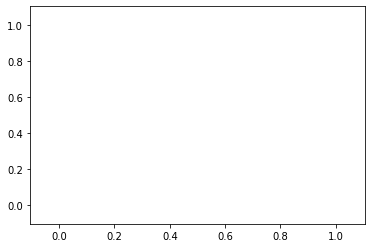

In [27]:
combined = read_h5ad(data_path + 'combined/Pilot1_Pilot2.Final.h5ad')
norm_X = combined.X
combined.X = combined.raw.X
del combined.raw

combined = combined[combined.obs['propagated_cell_ontology_class']!='unassigned']

combined.obs['propagated_cell_ontology_class'].replace('duodenum glandular cells','duodenum glandular cell',inplace=True)
combined.obs['manual_cell_ontology_class'].replace('duodenum glandular cells','duodenum glandular cell', inplace=True)
label_conversion = {}
for x in ontology.nodes:
    label_conversion[ontology.nodes[x]['name']] = x

combined.obs['propagated_cell_ontology_id'] = [label_conversion[x] for x in combined.obs['propagated_cell_ontology_class']]

train_data = scVIdata_preprocess(combined, 
                                 batch_col='donor_tech', 
                                 label_col='propagated_cell_ontology_class')
posterior = get_scvi_posterior(train_data, 
                               model_path+'Pilot12.all-minus-fat-heart.donor_tech.50.3.ss2_norm.scVI.pkl',
                               retrain=retrain, n_latent=50, n_layers=3)
posterior.gene_dataset.norm_X = norm_X

In [31]:
DEres = HierarchicalDE(ontology, 'CL:0000000', combined.obs['propagated_cell_ontology_id'], combined, 
                       method='scVI', posterior=posterior)

In [ ]:
for key in DEres.keys():
    name = ontology.nodes[key]['name']
    name = name.replace(' ', '_')
    writer = pd.ExcelWriter(data_path + 'HierarchicalDE/DE.hierarchical.scVI.%s.xlsx'%name, engine='xlsxwriter')
    res = DEres[key]
    groups = [res[2][i] for i in res[1]]
    for i,group in enumerate(groups):
        df = res[0][i]
        df = df[df['non_zeros_proportion1']>0.05]
        df = df[df['raw_normalized_mean1']>0.01]
        df = df[df['proba_de']>0.9]
        x = ontology.nodes[group]['name']
        x = x.replace('-positive','+')
        x = x.replace('-negative','-')
        x = x.replace('alpha-beta','ab')
        x = x.replace(', human','')
        x = x.replace(' cell','')
        x = x.replace('of epithelium of ','')
        x = x.replace('multipotent ', 'mp-')
        x = x.replace('multi-potent ', 'mp-')
        x = x.replace('associated', 'ass.')
        x = x.replace('epithelial of tracheobronchial tree', 'tracheobronchial epithelial')
        x = x.replace('lymphoid lineage restricted progenitor', 'lymphoid progenitor')
        df.to_excel(writer, sheet_name=x)
    
    writer.save()
